In [ ]:
!pip install yfinance

In [2]:

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import warnings
warnings.filterwarnings('ignore')

Prepare the Training Data

In [3]:
forex_data_1 = yf.download('EURUSD=X', start='2020-01-01', end='2021-12-31')

[*********************100%***********************]  1 of 1 completed


In [4]:
#Removing unnecessary columns
df=forex_data_1.drop(['Open', 'High', 'Low', 'Close', 'Volume'],axis=1) 
df.rename(columns={'Adj Close': 'eur'},inplace=True) 
df.head(2)

,eur
Date,
2020-01-01,1.122083
2020-01-02,1.122083


In [5]:
df = df.dropna(axis=0)

In [6]:
#Scaling the values between 0 to 1
from sklearn.preprocessing import MinMaxScaler
ss= MinMaxScaler(feature_range=(0,1))
train = ss.fit_transform(np.array(df["eur"]).reshape(-1,1))

In [7]:
# Feature selection
xtrain=[]
ytrain=[]
for i in range(60,len(train)):
    xtrain.append(train[i-60:i,0])
    ytrain.append(train[i,0])

xtrain, ytrain = np.array(xtrain), np.array(ytrain)

In [8]:
xtrain= np.reshape(xtrain,(xtrain.shape[0],xtrain.shape[1],1))

### Build a GRU Model

In [9]:
from keras.models import Sequential
from keras.layers import GRU
from keras.layers import Dense
from keras.layers import Dropout

In [ ]:
#initialisizng the model 
regression= Sequential()

#First Input layer and LSTM layer with 0.2% dropout
regression.add(GRU(units=50,return_sequences=True,kernel_initializer='glorot_uniform',input_shape=(xtrain.shape[1],1)))
regression.add(Dropout(0.2))

# Where:
#     return_sequences: Boolean. Whether to return the last output in the output sequence, or the full sequence.

# Second LSTM layer with 0.2% dropout
regression.add(GRU(units=50,kernel_initializer='glorot_uniform',return_sequences=True))
regression.add(Dropout(0.2))

#Third LSTM layer with 0.2% dropout
regression.add(GRU(units=50,kernel_initializer='glorot_uniform',return_sequences=True))
regression.add(Dropout(0.2))

#Fourth LSTM layer with 0.2% dropout, we wont use return sequence true in last layers as we dont want to previous output
regression.add(GRU(units=50,kernel_initializer='glorot_uniform'))
regression.add(Dropout(0.2))
#Output layer , we wont pass any activation as its continous value model
regression.add(Dense(units=1))

#Compiling the network
regression.compile(optimizer='adam',loss='mean_squared_error')


#fitting the network
regression.fit(xtrain,ytrain,batch_size=30,epochs=100)

Prepare the testing data

In [11]:
#regression.save('model.h5')

In [12]:
test_df = yf.download('EURUSD=X', start='2022-01-01', end='2022-06-30')

[*********************100%***********************]  1 of 1 completed


In [13]:
test = pd.DataFrame()
test['eur'] = test_df['Adj Close']
test = test.dropna()
total= pd.concat([df['eur'],test['eur']],axis=0) 
test_input = total[len(total)-len(test)-60:].values
test_input= test_input.reshape(-1,1) # reshaping it to get it transformed
test_input= ss.transform(test_input)
xtest= []
for i in range(60,80):
    xtest.append(test_input[i-60:i,0]) #creating input for lstm prediction
xtest= np.array(xtest)
xtest= np.reshape(xtest,(xtest.shape[0],xtest.shape[1],1))


In [19]:

predicted_value= regression.predict(xtest)

In [20]:
predicted_value= ss.inverse_transform(predicted_value)

In [21]:
test_actual = np.array(test['eur'][0:20])

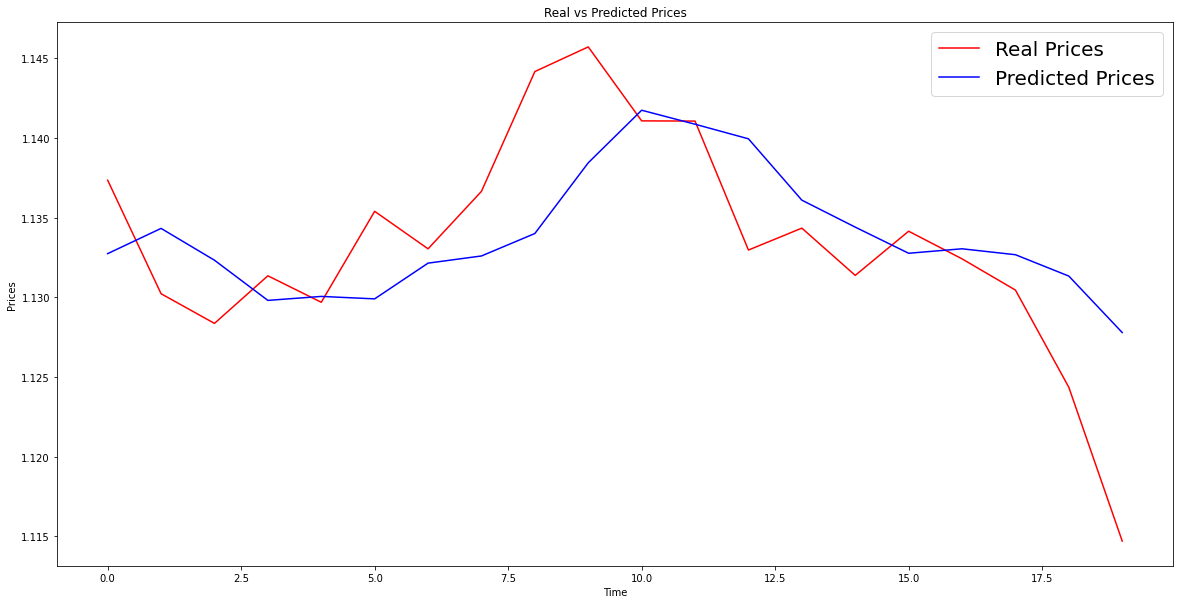

In [22]:
plt.figure(figsize=(20,10))
plt.plot(test_actual,'red',label='Real Prices')
plt.plot(predicted_value,'blue',label='Predicted Prices')
plt.xlabel('Time')
plt.ylabel('Prices')
plt.title('Real vs Predicted Prices')
plt.legend(loc='best', fontsize=20)

In [23]:
from sklearn.metrics import r2_score
r2_score(test_actual, predicted_value)

0.4008448006334897

Change parameters and see performance

In [ ]:
#Change the number of epochs
regression.fit(xtrain,ytrain,batch_size=30,epochs=250)

In [26]:

predicted_value= regression.predict(xtest)
predicted_value= ss.inverse_transform(predicted_value)
test_actual = np.array(test['eur'][0:20])
r2_score(test_actual, predicted_value)


0.49919212916810773

So our change in epochs increase the r2_score from 0.4 to 0.5 

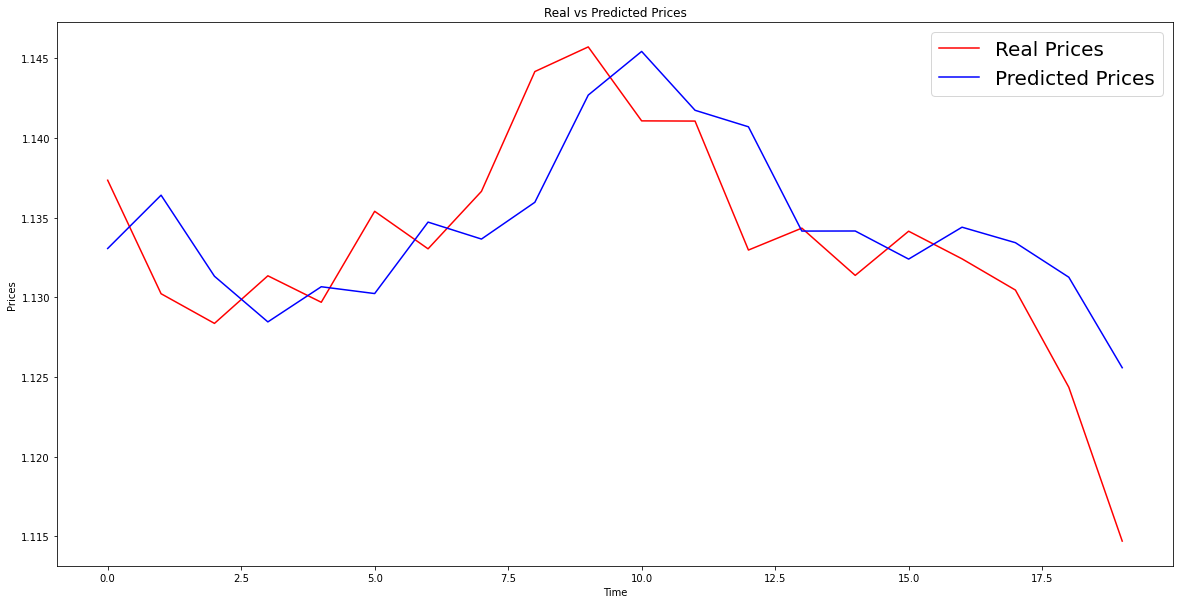

In [27]:
plt.figure(figsize=(20,10))
plt.plot(test_actual,'red',label='Real Prices')
plt.plot(predicted_value,'blue',label='Predicted Prices')
plt.xlabel('Time')
plt.ylabel('Prices')
plt.title('Real vs Predicted Prices')
plt.legend(loc='best', fontsize=20)